In [127]:
import pandas as pd
import numpy as np

import os
for dirname, _, filenames in os.walk('~/workspace/mast1_ai/electives_fy/maths_f/house_predict/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [212]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

from scipy.stats import norm, skew
from scipy.special import boxcox1p

In [129]:
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')

In [130]:
train = pd.read_csv('~/workspace/mast1_ai/electives_fy/maths_f/house_predict/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [131]:
test = pd.read_csv('~/workspace/mast1_ai/electives_fy/maths_f/house_predict/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [132]:
print("Shape of train data:", train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)


# Making a copy of training data

In [133]:
train_copy = train.copy()
test_copy = test.copy()

In [134]:
num_cols = train._get_numeric_data().columns 
display(num_cols)
print()
print("Count:", len(num_cols))

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


Count: 38


# Drawing box plots to check for outliers

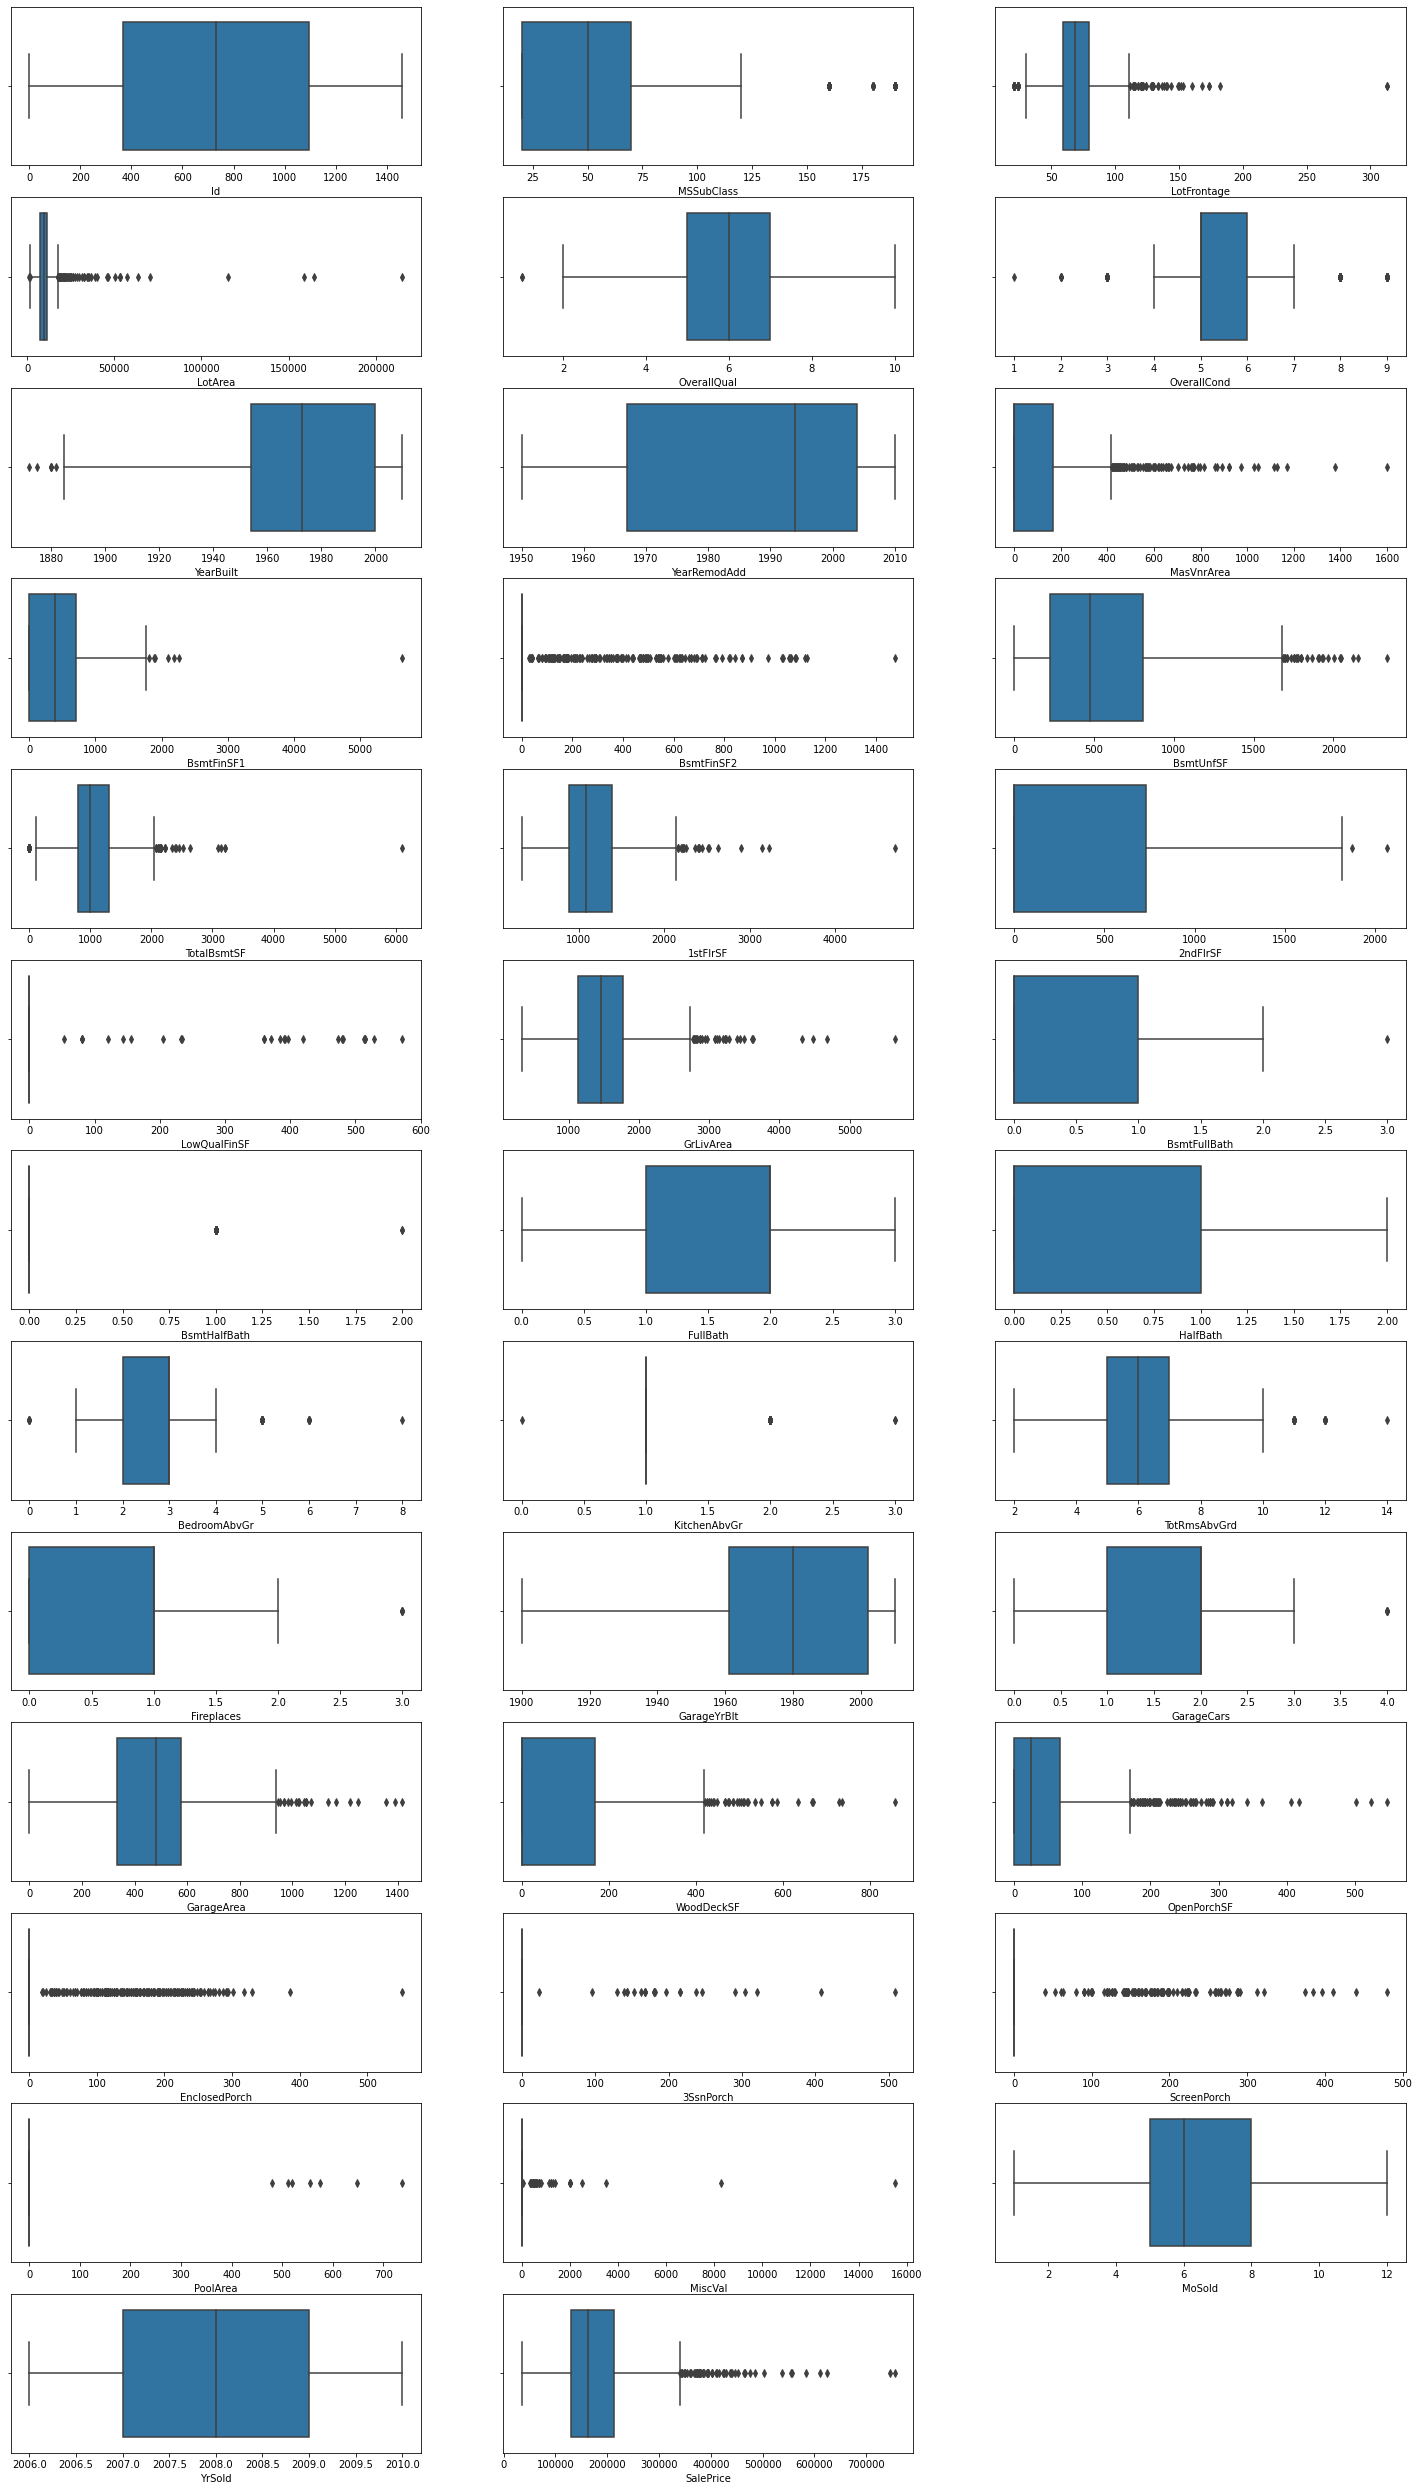

In [135]:
plt.figure(figsize = (25,45))
for i in enumerate(num_cols):
  plt.subplot(13,3,i[0]+1)
  sns.boxplot(train[i[1]])
  plt.xlabel(i[1])

# Index's to be removed from train set

In [136]:
index = [712, 1219, 1416, 1200, 1345, 1458, 773, 1248, 1423, 628, 973, 1458, 1459]
train = train.drop(labels = index, axis = 0)

print("Shape of train data:", train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (1448, 81)
Shape of test data: (1459, 80)


## Print colum with null values 

In [137]:
Null_train = train.isnull().sum()
Null_train[Null_train > 0]

LotFrontage      258
Alley           1358
MasVnrType         7
MasVnrArea         7
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      682
GarageType        80
GarageYrBlt       80
GarageFinish      80
GarageQual        80
GarageCond        80
PoolQC          1442
Fence           1168
MiscFeature     1395
dtype: int64

## Creating a list of columns to be removed and removing from train and test sets, assuming the columns with highest number
## of missing values are likely to be in Test set

In [138]:
drop_columns = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Id']
train = train.drop(drop_columns, axis =1)
test = test.drop(drop_columns, axis = 1)

print("Shape of train data:", train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (1448, 76)
Shape of test data: (1459, 75)


# Analysing the null data in training set


In [139]:
Null_train_data = train[['LotFrontage', 'FireplaceQu', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
      'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']]

# Creating a function with name 'analysis' for extracting data type, unique and null count


In [140]:
def analysis(data):
    return pd.DataFrame({"Data Type":data.dtypes, "Unique Count":data.apply(lambda x: x.nunique(),axis=0), 
                         "Null Count": data.isnull().sum() })

In [141]:
analysis(Null_train_data)

,Data Type,Unique Count,Null Count
LotFrontage,float64,110,258
FireplaceQu,object,5,682
MasVnrType,object,4,7
MasVnrArea,float64,327,7
BsmtQual,object,4,37
BsmtCond,object,4,37
BsmtExposure,object,4,38
BsmtFinType1,object,6,37
BsmtFinType2,object,6,38
Electrical,object,5,1


In [142]:
Null_train_data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1190.000000,1441.000000,1368.000000
mean,70.126050,104.179042,1978.557749
std,24.317896,181.522852,24.732415
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.500000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


# Replacing numeric null vlaues for training set

In [143]:
train['LotFrontage'] = train['LotFrontage'].fillna((train['LotFrontage'].mean()))
train['MasVnrArea'] = train['MasVnrArea'].fillna((train['MasVnrArea'].mode()[0]))
train['GarageYrBlt'] = train['GarageYrBlt'].fillna((train['GarageYrBlt'].mode()[0]))

In [144]:
Null_test = test.isnull().sum()
Null_test[Null_test > 0]

MSZoning          4
LotFrontage     227
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       16
MasVnrArea       15
BsmtQual         44
BsmtCond         45
BsmtExposure     44
BsmtFinType1     42
BsmtFinSF1        1
BsmtFinType2     42
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
FireplaceQu     730
GarageType       76
GarageYrBlt      78
GarageFinish     78
GarageCars        1
GarageArea        1
GarageQual       78
GarageCond       78
SaleType          1
dtype: int64

In [145]:
Null_test_data = test[['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 
                         'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
                         'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 
                         'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCars','GarageArea', 
                         'GarageQual', 'GarageCond', 'SaleType']]
analysis(Null_test_data)

,Data Type,Unique Count,Null Count
MSZoning,object,5,4
LotFrontage,float64,115,227
Utilities,object,1,2
Exterior1st,object,13,1
Exterior2nd,object,15,1
MasVnrType,object,4,16
MasVnrArea,float64,303,15
BsmtQual,object,4,44
BsmtCond,object,4,45
BsmtExposure,object,4,44


In [146]:
Null_test_data[['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
                'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
count,1232.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1457.000000,1457.000000,1381.000000,1458.000000,1458.000000
mean,68.580357,100.709141,439.203704,52.619342,554.294925,1046.117970,0.434454,0.065202,1977.721217,1.766118,472.768861
std,22.376841,177.625900,455.268042,176.753926,437.260486,442.898624,0.530648,0.252468,26.431175,0.775945,217.048611
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000
25%,58.000000,0.000000,0.000000,0.000000,219.250000,784.000000,0.000000,0.000000,1959.000000,1.000000,318.000000
50%,67.000000,0.000000,350.500000,0.000000,460.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,480.000000
75%,80.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1.000000,0.000000,2002.000000,2.000000,576.000000
max,200.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000


# Replacing numeric Null vlaues for testing set

In [147]:
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].mean())
test['MasVnrArea'] = test['MasVnrArea'].fillna(test['MasVnrArea'].mode()[0])
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(test['BsmtFinSF1'].mode()[0])
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(test['BsmtFinSF2'].mode()[0])
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(test['BsmtUnfSF'].mean())
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean())
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(test['BsmtFullBath'].mode()[0])
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(test['BsmtHalfBath'].mode()[0])
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['GarageYrBlt'].mode()[0])
test['GarageCars'] = test['GarageCars'].fillna(test['GarageCars'].mode()[0])
test['GarageArea'] = test['GarageArea'].fillna(test['GarageArea'].mean())

# Data Cleaning

In [148]:
def correlation(data, limit):
  col = set()
  corr_matrix = data.corr()
  for i in range(len(corr_matrix)):
    for j in range(i):
      if (corr_matrix.iloc[i, j]) > limit:
        col_name = corr_matrix.columns[i]
        col.add(col_name)
  return col

In [149]:
corr_columns = correlation(train, 0.7)
corr_columns

{'1stFlrSF', 'GarageArea', 'GarageYrBlt', 'SalePrice', 'TotRmsAbvGrd'}

Dropping MiscFeature and MiscVal as their contribution towards the sale values doesnt seem much

In [150]:
train = train.drop(['1stFlrSF', 'GarageArea', 'TotRmsAbvGrd'], axis = 1)
test = test.drop(['1stFlrSF', 'GarageArea', 'TotRmsAbvGrd'], axis = 1)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,854,0,1710,1,0,2,1,3,1,Gd,Typ,0,NaN,Attchd,2003.0,RFn,2,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,0,0,1262,0,1,2,0,3,1,TA,Typ,1,TA,Attchd,1976.0,RFn,2,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,866,0,1786,1,0,2,1,3,1,Gd,Typ,1,TA,Attchd,2001.0,RFn,2,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,756,0,1717,1,0,1,0,3,1,Gd,Typ,1,Gd,Detchd,1998.0,Unf,3,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1053,0,2198,1,0,2,1,4,1,Gd,Typ,1,TA,Attchd,2000.0,RFn,3,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


# Separating target variable 

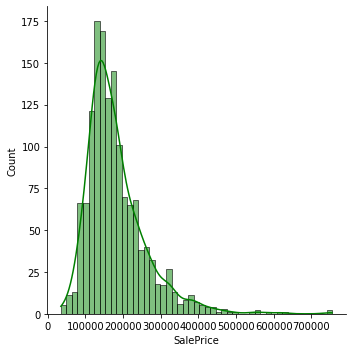

In [151]:
House_Price = pd.DataFrame(train['SalePrice'])
train = train.drop(['SalePrice'], axis = 1)

sns.displot(House_Price['SalePrice'], kde = True, color = 'Green')

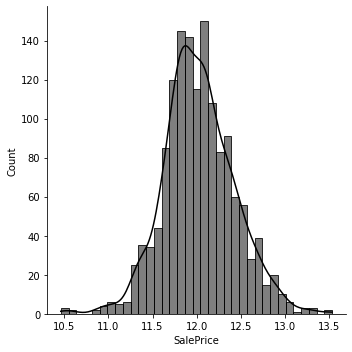

In [152]:
sns.displot(np.log(House_Price['SalePrice']), kde = True, color = 'Black')

# Applying log on target variable

In [153]:
House_Price = pd.DataFrame(np.log(House_Price['SalePrice']))

print("Shape of train data:", train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (1448, 72)
Shape of test data: (1459, 72)


In [154]:
data = pd.concat([train, test])
data.shape

(2907, 72)

# Generating new columns

In [155]:
#data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['YrBltRemod'] = data['YearBuilt'] + data['YearRemodAdd']
data['TotalBathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) +
                               data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
data['TotalPorchSf'] = (data['OpenPorchSF'] + data['3SsnPorch'] +
                              data['EnclosedPorch'] + data['ScreenPorch'] +
                              data['WoodDeckSF'])

#data["LivLotRatio"] = data['GrLivArea']/data['LotArea']

data["TotalOutsideSF"] = sum((data['WoodDeckSF'],data['OpenPorchSF'],data['EnclosedPorch'], data['ScreenPorch']))

data['HouseAge'] = data['YrSold'] - data['YearBuilt']

data['OverallCondQual'] = (data['OverallCond'] + data['OverallQual'])/2

In [156]:
data_num_cols = data._get_numeric_data().columns 
data_num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'YrBltRemod', 'TotalBathrooms',
       'TotalPorchSf', 'TotalOutsideSF', 'HouseAge', 'OverallCondQual'],
      dtype='object')

In [157]:
data_cat_cols = data.columns.difference(data_num_cols)
data_cat_cols

Index(['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu',
       'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual',
       'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning',
       'MasVnrType', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType', 'Street', 'Utilities'],
      dtype='object')

# Separating both numeric and categorical data from set

In [158]:
data_num_data = data.loc[:, data_num_cols]
data_cat_data = data.loc[:, data_cat_cols]

print("Shape of num data:", data_num_data.shape)
print("Shape of cat data:", data_cat_data.shape)

Shape of num data: (2907, 39)
Shape of cat data: (2907, 39)


# Scaling numeric variables 

In [159]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [160]:
s_scaler = StandardScaler()
data_num_data_s = s_scaler.fit_transform(data_num_data)

data_num_data_s = pd.DataFrame(data_num_data_s, columns = data_num_cols)

## Scaling categorical variables 

In [161]:
data_cat_data = data_cat_data.fillna('NA')

label = LabelEncoder()
data_cat_data = data_cat_data.astype(str).apply(LabelEncoder().fit_transform)

In [162]:
data_num_data.isnull().sum()

MSSubClass         0
LotFrontage        0
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
Fireplaces         0
GarageYrBlt        0
GarageCars         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
YrBltRemod         0
TotalBathrooms     0
TotalPorchSf       0
TotalOutsideSF     0
HouseAge           0
OverallCondQual    0
dtype: int64

In [163]:
data_num_data_s.reset_index(drop=True, inplace=True)
data_cat_data.reset_index(drop=True, inplace=True)

data_new = pd.concat([data_num_data_s, data_cat_data], axis = 1)

train_new = data_new.loc[:1447,]
test_new = data_new.loc[1448:,]

print("Shape of train data:", train_new.shape)
print("Shape of test data:", test_new.shape)

Shape of train data: (1448, 78)
Shape of test data: (1459, 78)


# Spliting data

In [164]:
from sklearn.model_selection import train_test_split 

trainx,valx,trainy,valy = train_test_split(train_new,House_Price,test_size=0.2,random_state=1234)
#print(cust_data.shape)
print(trainx.shape)
print(valx.shape)

(1158, 78)
(290, 78)


# Model Fiting

In [169]:
import xgboost

xgb = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colasample_bytree=0.2,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0.1, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=1,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

xgb.fit(trainx,trainy)

[11:59:38] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:38] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { colasample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colasample_bytree=0.2,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0.1, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=1,
             monotone_constraints='()', n_estimators=100, n_jobs=1, nthread=1,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=1, tree_method='exact', validate_parameters=1, ...)

# Model Prediction

In [174]:
xgb_train_pred = xgb.predict(trainx)
xgb_val_pred = xgb.predict(valx)

# Calculationg RMSE values

In [175]:
xgb_train_rmse = mean_squared_error(trainy, xgb_train_pred, squared=False)
xgb_val_rmse = mean_squared_error(valy, xgb_val_pred, squared=False)

print("Train RMSE: ", xgb_train_rmse)
print("Test RMSE: ", xgb_val_rmse)

Train RMSE:  0.08221832123986328
Test RMSE:  0.14468579852630806


In [176]:
xgb_test_pred = xgb.predict(test_new)

## Storing values in dataframe : submission_xgb

In [178]:
submission_xgb = pd.DataFrame(test_copy[['Id']])
submission_xgb['SalePrice'] = np.exp(xgb_test_pred)
submission_xgb.head()

,Id,SalePrice
0,1461,125605.703125
1,1462,157069.125000
2,1463,172117.546875
3,1464,186156.328125
4,1465,187589.375000


In [179]:
c = np.isinf(submission_xgb['SalePrice']).values.sum()
print("It contains " + str(c) + " infinite values")

It contains 0 infinite values


# Model fiting

In [183]:
lasso_model = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])

lasso_model.fit(trainx, trainy)
lasso_model.get_params()

{'alphas': [1, 0.1, 0.001, 0.0005],
 'copy_X': True,
 'cv': None,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': False,
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

# Model Predilection

In [184]:
lso_train_pred = lasso_model.predict(trainx)
lso_val_pred = lasso_model.predict(valx)

## Calculating RMSE values

In [186]:
lso_train_rmse = mean_squared_error(trainy, lso_train_pred, squared=False)
lso_val_rmse = mean_squared_error(valy, lso_val_pred, squared=False)

print("Train RMSE: ", lso_train_rmse)
print("Test RMSE: ",lso_val_rmse)

Train RMSE:  0.1332592689898713
Test RMSE:  0.148556656979795


# Predicting test values

In [190]:
lso_test_pred = lasso_model.predict(test_new)

# Storing values in a dataframe: submission_ls

In [191]:
submission_ls = pd.DataFrame(test_copy[['Id']])
submission_ls['SalePrice'] = np.exp(lso_test_pred)
submission_ls.head()

,Id,SalePrice
0,1461,114864.674386
1,1462,155799.689448
2,1463,169438.694983
3,1464,198268.172654
4,1465,188171.130871


In [192]:
a = np.isinf(submission_ls['SalePrice']).values.sum()
print("It contains " + str(a) + " infinite values")

It contains 0 infinite values


# Model Fiting

In [195]:
lr = LinearRegression()
lr.fit(trainx, trainy)

LinearRegression()

# Model Predictions

In [198]:
lr_train_pred = lr.predict(trainx)
lr_val_pred = lr.predict(valx)

# Calculation RMSE values

In [201]:
lr_train_rmse = mean_squared_error(trainy, lr_train_pred, squared=False)
lr_val_rmse = mean_squared_error(valy, lr_val_pred, squared=False)

print("Train RMSE: ", lr_train_rmse)
print("Test RMSE: ",lr_val_rmse)

Train RMSE:  0.14673345578613087
Test RMSE:  0.16083195542532602


# Predicting on test set

In [203]:
lr_test_pred = lr.predict(test_new)

In [204]:
submission_lr = pd.DataFrame(test_copy[['Id']])
submission_lr['SalePrice'] = np.exp(lr_test_pred)
submission_lr.head()

,Id,SalePrice
0,1461,109641.655053
1,1462,158989.500155
2,1463,160583.380686
3,1464,185754.220726
4,1465,187192.300778


# Storing values in a dataframe: submission_lr

In [205]:
submission_lr = pd.DataFrame(test_copy[['Id']])
submission_lr['SalePrice'] = np.exp(lr_test_pred)
submission_lr.head()

,Id,SalePrice
0,1461,109641.655053
1,1462,158989.500155
2,1463,160583.380686
3,1464,185754.220726
4,1465,187192.300778


In [206]:
x = np.isinf(submission_lr['SalePrice']).values.sum()
print("It contains " + str(x) + " infinite values")

It contains 0 infinite values


# Model Fiting

In [213]:
cat = CatBoostRegressor(random_state=0,verbose=False, depth = 5, early_stopping_rounds=300, learning_rate= 0.1)
cat.fit(trainx, trainy)

# Model Predictions

In [214]:
cat_train_pred = cat.predict(trainx)
cat_val_pred = cat.predict(valx)

# Calculating RMSE values

In [215]:
cat_train_rmse = mean_squared_error(trainy, cat_train_pred, squared=False)
cat_val_rmse = mean_squared_error(valy, cat_val_pred, squared=False)

print("Train RMSE: ", cat_train_rmse)
print("Test RMSE: ",cat_val_rmse)

Train RMSE:  0.015877985599047496
Test RMSE:  0.12281046543957957


# Predicting on test set

In [216]:
cat_test_pred = cat.predict(test_new)

# Storing values in a dataframe: submission_cat

In [217]:
submission_cat = pd.DataFrame(test_copy[['Id']])
submission_cat['SalePrice'] = np.exp(cat_test_pred)
submission_cat.head()

,Id,SalePrice
0,1461,126424.426596
1,1462,159588.566820
2,1463,184419.355093
3,1464,197714.795683
4,1465,178024.800800


In [218]:
b = np.isinf(submission_cat['SalePrice']).values.sum()
print("It contains " + str(b) + " infinite values")

It contains 0 infinite values


In [219]:
submission_file = pd.DataFrame()
submission_file['Id'] = test_copy['Id']
submission_file['SalePrice'] = (submission_xgb['SalePrice']+submission_ls['SalePrice']+submission_cat['SalePrice'])/3
#submission_file['SalePrice'] = (submission_xgb['SalePrice']+submission_ls['SalePrice']+submission_lr['SalePrice']+submission_cat['SalePrice'])/4
submission_file.head()

,Id,SalePrice
0,1461,122298.268036
1,1462,157485.793756
2,1463,175325.198984
3,1464,194046.432154
4,1465,184595.102224


In [220]:
w = np.isinf(submission_file['SalePrice']).values.sum()
print("It contains " + str(w) + " infinite values")

It contains 0 infinite values


In [221]:
submission_file.to_csv("Submission.csv", index = False)